# Factor Momentum (US)

We explore if factor out-performance persists in US factor/strategy indices.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()
eqUs <- EquitiesUs()

In [2]:
barclaysIndices <- c('BXIIMUTU', #Momentum
                    'BXIIKUTU', #Quality
                    'BXIILUTU', #Low Volatility
                    'BXIIVUTU' #Value
                    )

etfs <- c('SPY', #large-cap
         'MDY' #mid-cap
         )

indexNames <- c(barclaysIndices, etfs)

startDate <- as.Date('2005-01-01')
endDate <- as.Date('2019-12-30')

In [3]:
monthlies <- NULL
for(iName in barclaysIndices){
    px <- indices$BarclaysTimeSeries() %>%
        filter(TICKER == iName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    monthlies <- merge.xts(monthlies, Common.NormalizeMonthlyDates(monthlyReturn(xts(px$CLOSE, px$TIME_STAMP))))
}

for(iName in etfs){
    px <- eqUs$EodAdjustedTimeSeries() %>%
        filter(SYMBOL == iName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    monthlies <- merge.xts(monthlies, Common.NormalizeMonthlyDates(monthlyReturn(xts(px$CLOSE, px$TIME_STAMP))))
}

monthlies <- monthlies[-1,]
monthlies <- monthlies[-nrow(monthlies), ]
names(monthlies) <- indexNames

In [4]:
allRets <- na.omit(merge(monthlies, stats::lag(monthlies, -1)))

In [5]:
print(head(allRets))

               BXIIMUTU    BXIIKUTU     BXIILUTU     BXIIVUTU         SPY
2005-02-20  0.046434389  0.02855257  0.016813255  0.057713340  0.02090386
2005-03-20 -0.008450095 -0.01881229 -0.005932797 -0.006109853 -0.02213380
2005-04-20 -0.062367363 -0.02648002  0.003320461 -0.025912348 -0.01873516
2005-05-20  0.050360705  0.04027365  0.011172692  0.029905671  0.03222462
2005-06-20  0.049010988 -0.00949237 -0.006504013  0.025095326 -0.00251088
2005-07-20  0.040617447  0.02945177  0.019995593  0.034505814  0.03826145
                   MDY   BXIIMUTU.1  BXIIKUTU.1   BXIILUTU.1   BXIIVUTU.1
2005-02-20  0.03640982 -0.008450095 -0.01881229 -0.005932797 -0.006109853
2005-03-20 -0.01633987 -0.062367363 -0.02648002  0.003320461 -0.025912348
2005-04-20 -0.03712625  0.050360705  0.04027365  0.011172692  0.029905671
2005-05-20  0.05710342  0.049010988 -0.00949237 -0.006504013  0.025095326
2005-06-20  0.02203182  0.040617447  0.02945177  0.019995593  0.034505814
2005-07-20  0.05133733  0.016128131 -0

In [6]:
makePlots <- function(factorMomXts, mainTitle, subTitle){
    toPlot <- merge(factorMomXts$RET, allRets[, 'SPY.1'])
    names(toPlot) <- c('FACTOR_MOM', 'BENCH')
    Common.PlotCumReturns(toPlot, mainTitle, subTitle)
    
    cum12mo <- merge(rollapply(toPlot$FACTOR_MOM, 12, Return.cumulative, by=12), rollapply(toPlot$BENCH, 12, Return.cumulative, by=12))
    cum12mo <- na.omit(cum12mo)
    cum12moDf <- data.frame(100.0*cum12mo)
    names(cum12moDf) <- c('FACTOR_MOM', 'BENCH')
    cum12moDf$T <- as.Date(index(cum12mo))
    
    cum12moDf2 <- melt(cum12moDf, id='T')
    
    g1 <- ggplot(cum12moDf2, aes(x=T, y=value, fill=variable)) +
        theme_economist() +
        theme(axis.text.x=element_text(angle=90, hjust=1)) +
        geom_bar(stat="identity", position=position_dodge()) +
        scale_x_date(breaks=cum12moDf$T, date_labels="%Y-%b") +
        geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
        labs(x='', y='(%)', fill='', title=mainTitle, subtitle=sprintf("%s; 12-mo returns", subTitle)) +
        annotate("text", x=max(cum12moDf$T), y=min(cum12moDf2$value), 
                 label = "@StockViz", hjust=1.1, vjust=-1.1, 
                 col="white", cex=6, fontface = "bold", alpha = 0.8)  
    
    print(g1)
    
    factorLongs <- data.frame(F = coredata(factorMomXts$F), T = index(factorMomXts))
    factorLongs$F <- indexNames[factorLongs$F]
    factorLongs$F <- factor(factorLongs$F, levels=unique(factorLongs$F))

    xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

    g2 <- ggplot(factorLongs, aes(x=T, y=F)) +
        theme_economist() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_point() +
        scale_x_date(breaks = xAxisTicks) +
        labs(x='', y='', fill='', title=mainTitle, subtitle=sprintf("%s [%s:%s]", subTitle, startDate, endDate)) +
        annotate("text", x=endDate, y=1, 
                 label = "@StockViz", hjust=1.1, vjust=-1.1, 
                 col="white", cex=6, fontface = "bold", alpha = 0.8)
    
    print(g2)
}

## Buy whatever gave highest returns in the last 12-months

In [7]:
lb <- 12
factorMomXts <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        cumRets <- c(cumRets, as.numeric(Return.cumulative(X[,i])))
    }
    maxIndex <- which.max(cumRets)
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

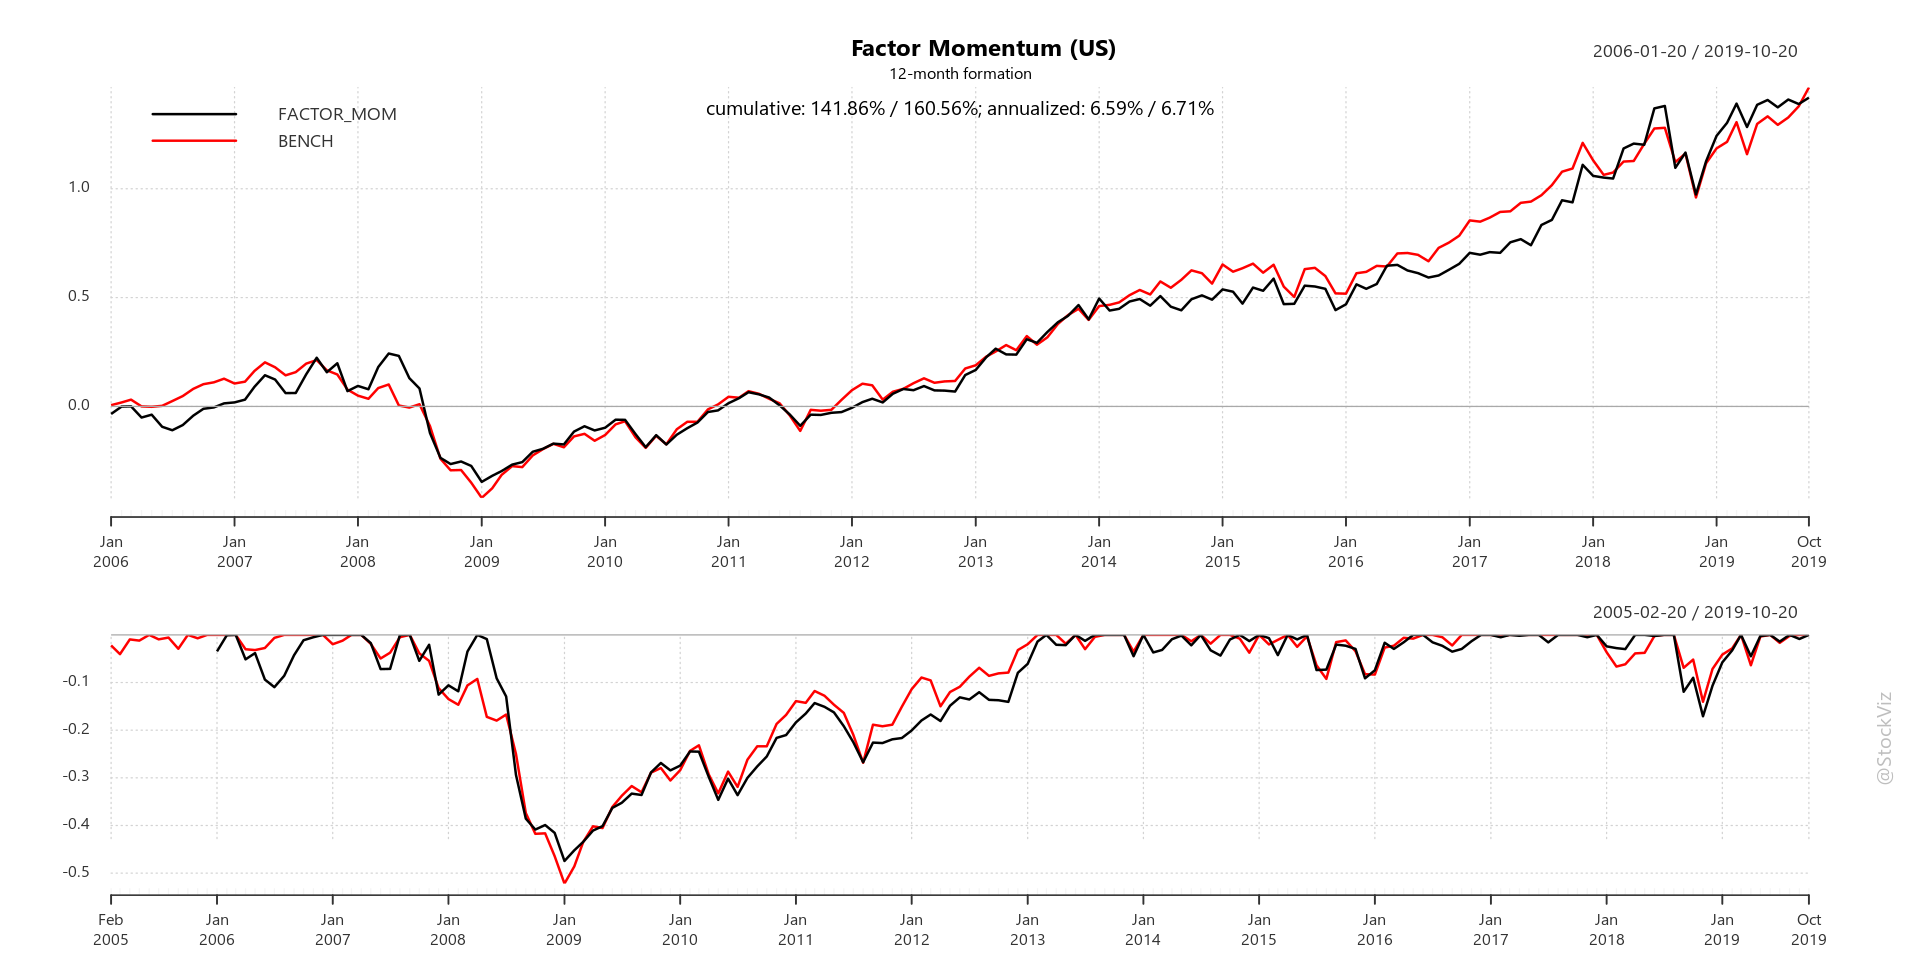

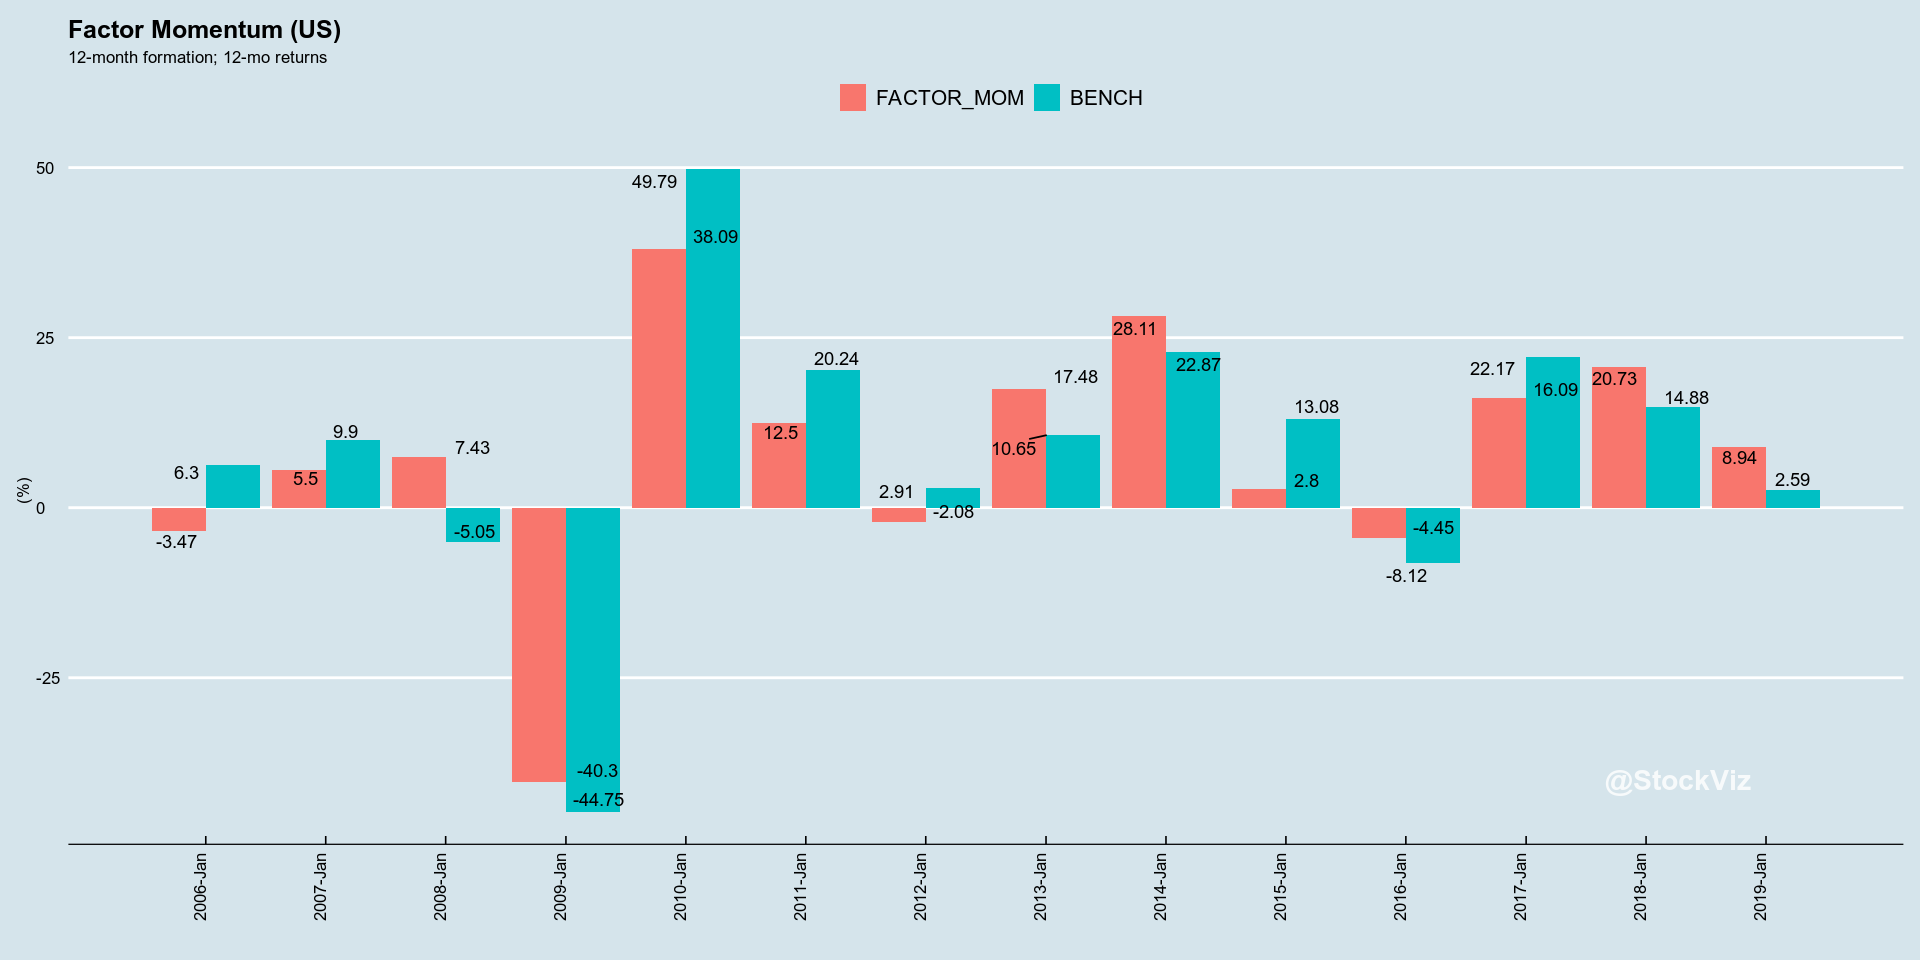

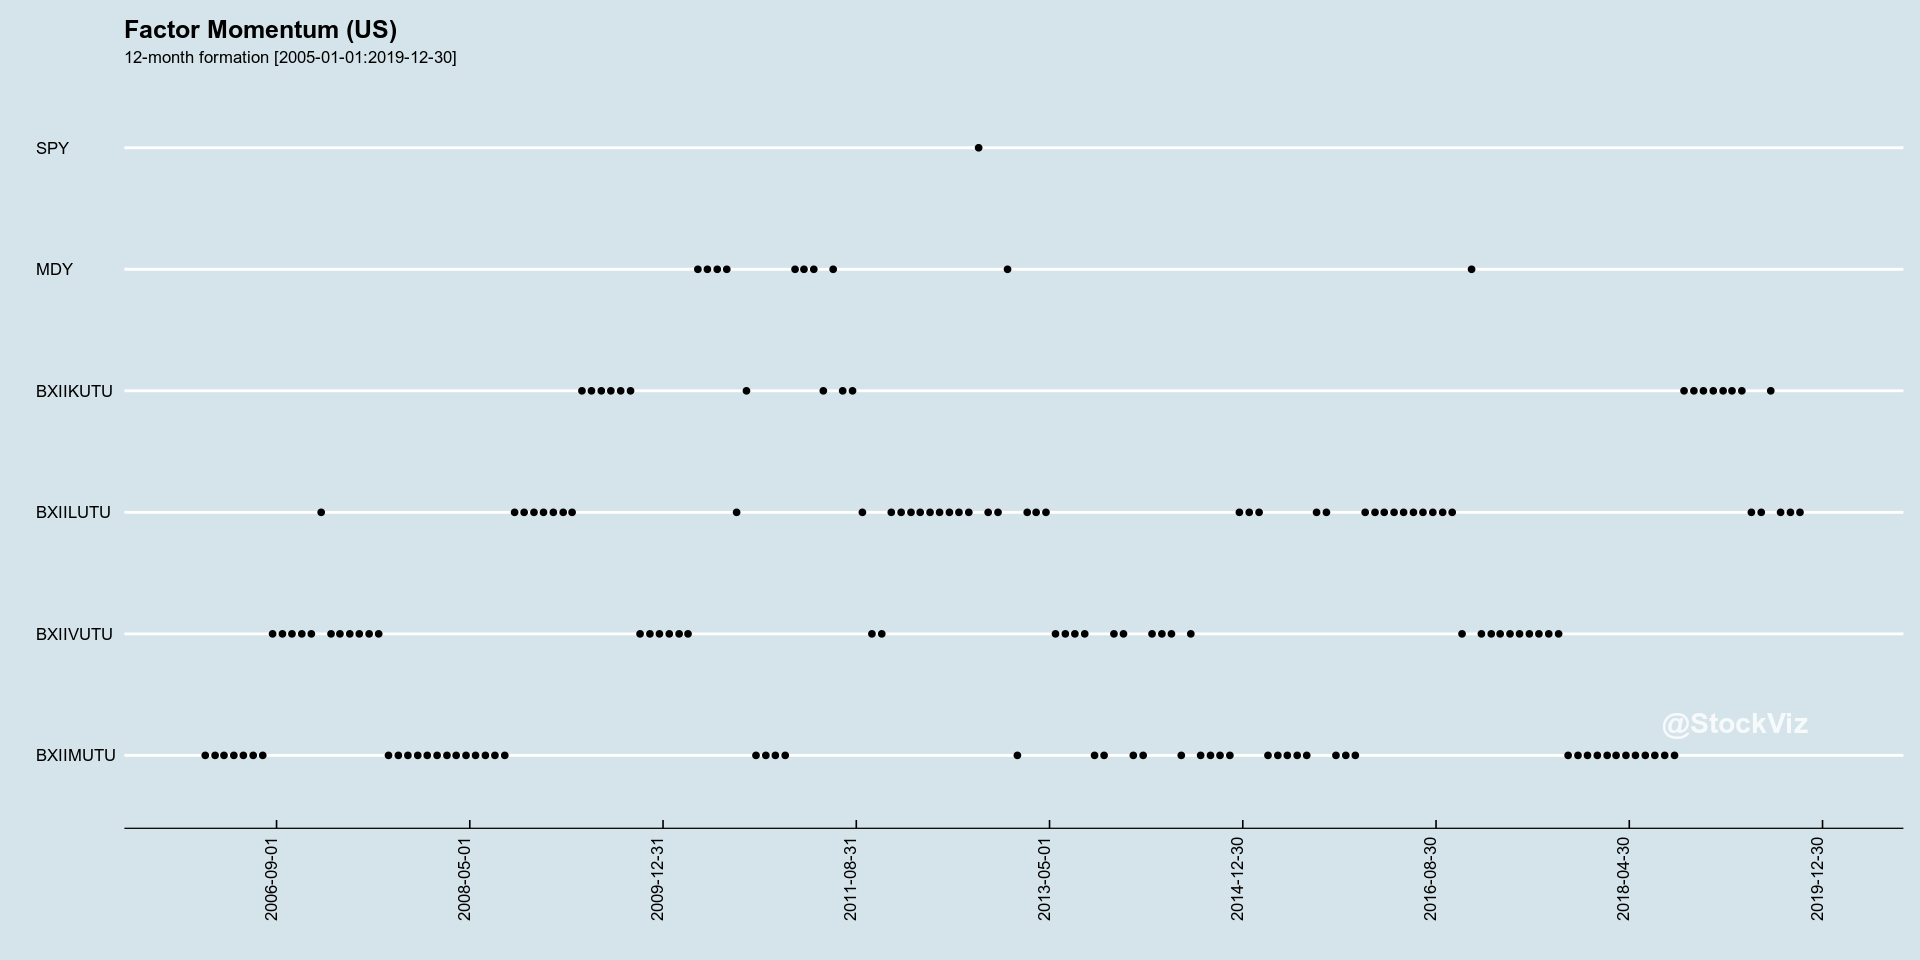

In [8]:
makePlots(factorMomXts, "Factor Momentum (US)", "12-month formation")

## Buy whatever had the highest average returns over the last 6, 7, 8, 9, 10, 11 and 12-months

In [9]:
lb <- 12
factorMomXts2 <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        totalRet <- as.numeric(Return.cumulative(X[7:12,i])) +
            as.numeric(Return.cumulative(X[6:12,i])) +
            as.numeric(Return.cumulative(X[5:12,i])) +
            as.numeric(Return.cumulative(X[4:12,i])) + 
            as.numeric(Return.cumulative(X[3:12,i])) +
            as.numeric(Return.cumulative(X[2:12,i])) +
            as.numeric(Return.cumulative(X[1:12,i]))
        cumRets <- c(cumRets, totalRet/7)
    }
    maxIndex <- which.max(cumRets)
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts2 <- na.omit(factorMomXts2)
names(factorMomXts2) <- c('F', 'RET')

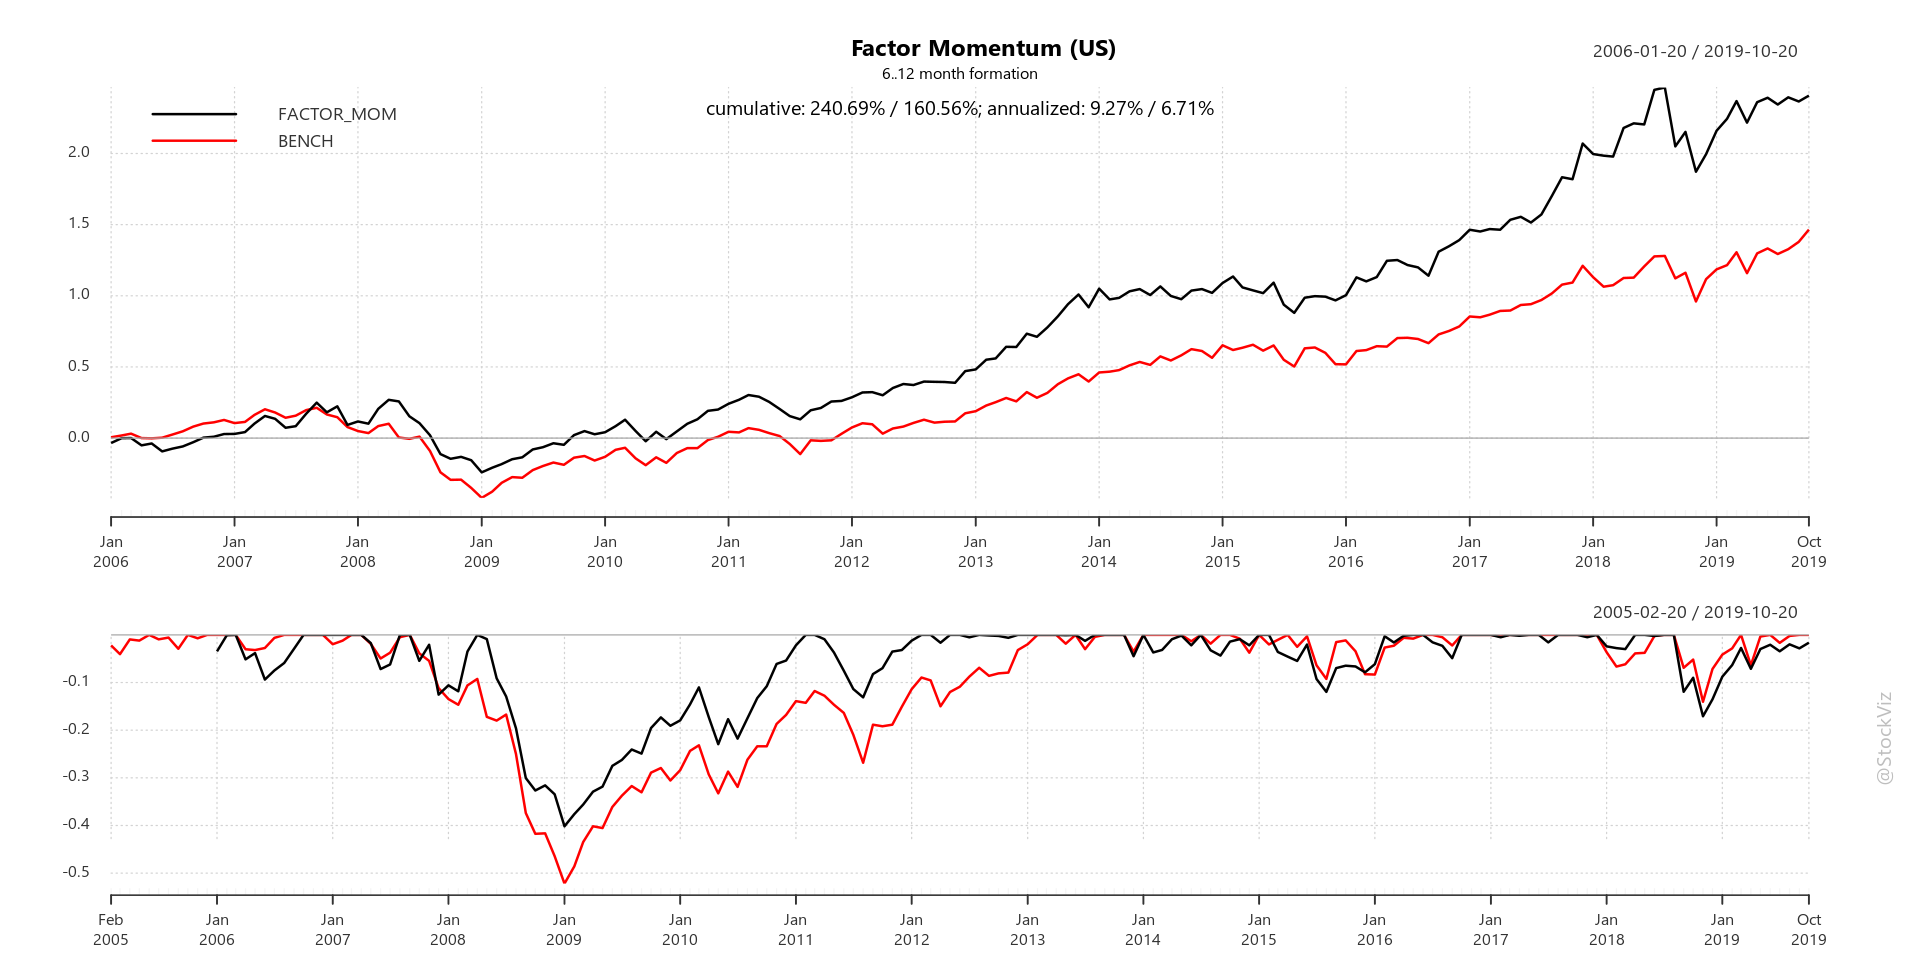

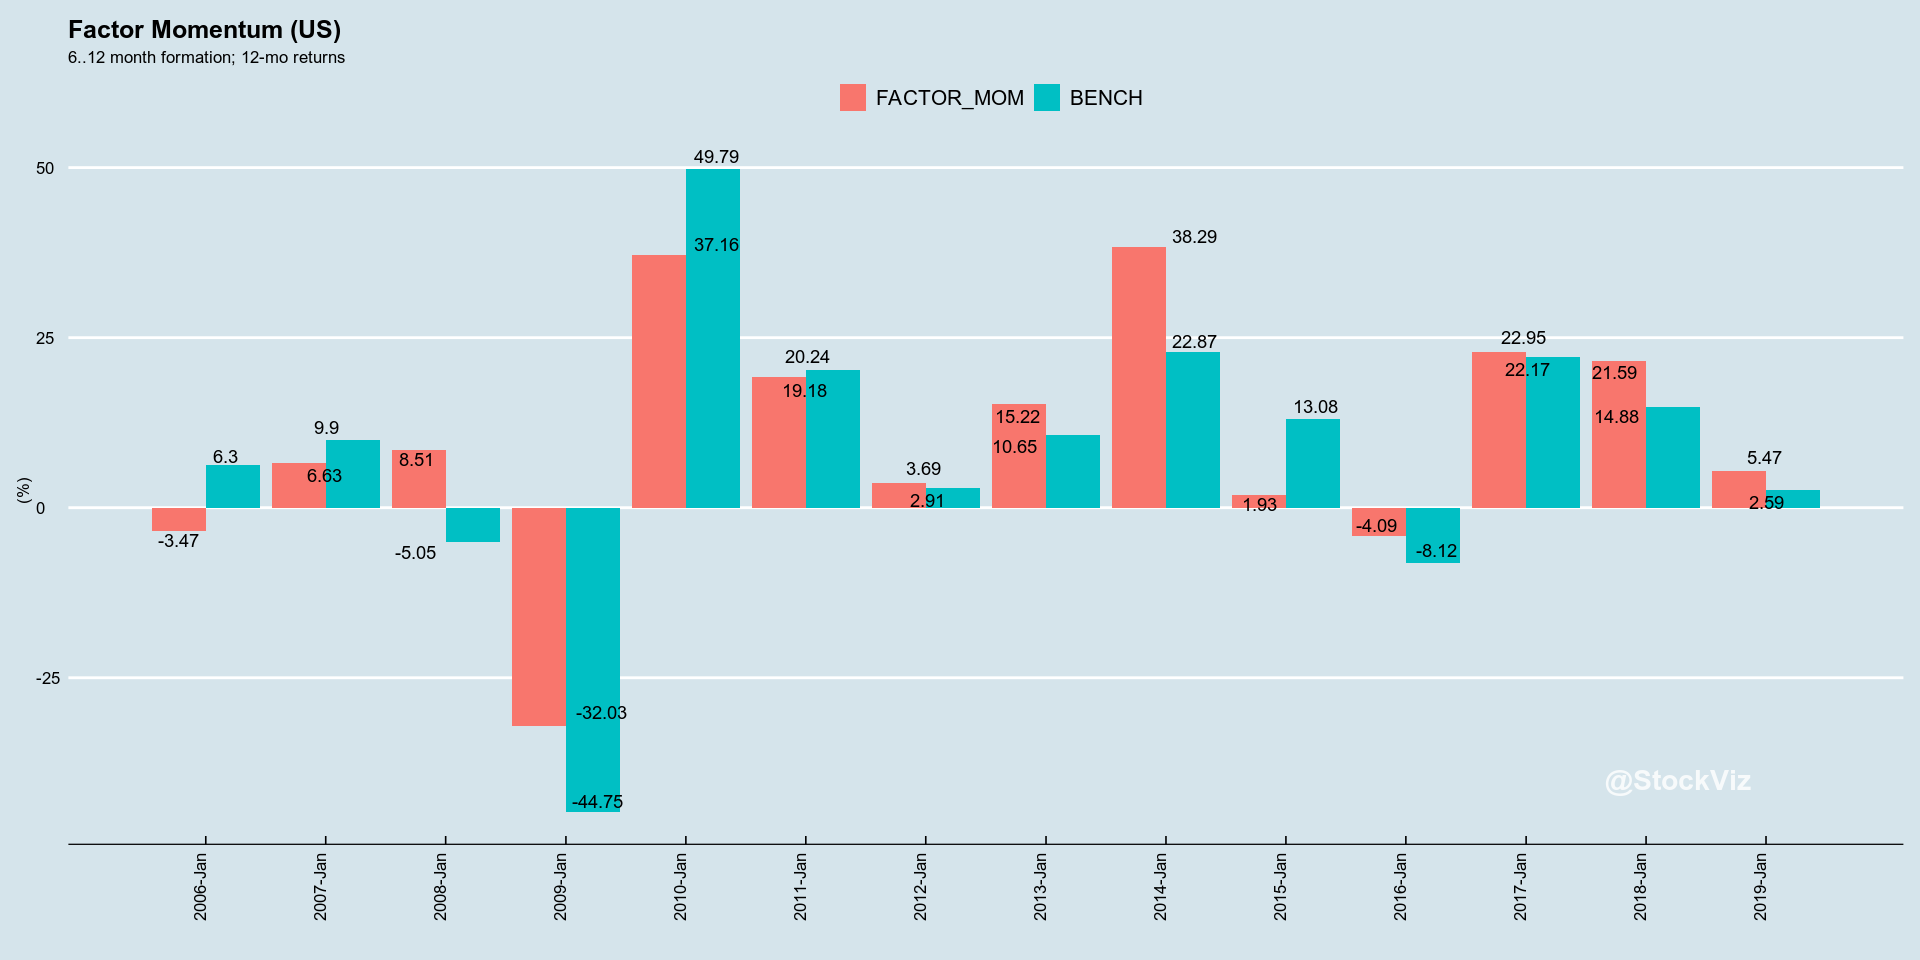

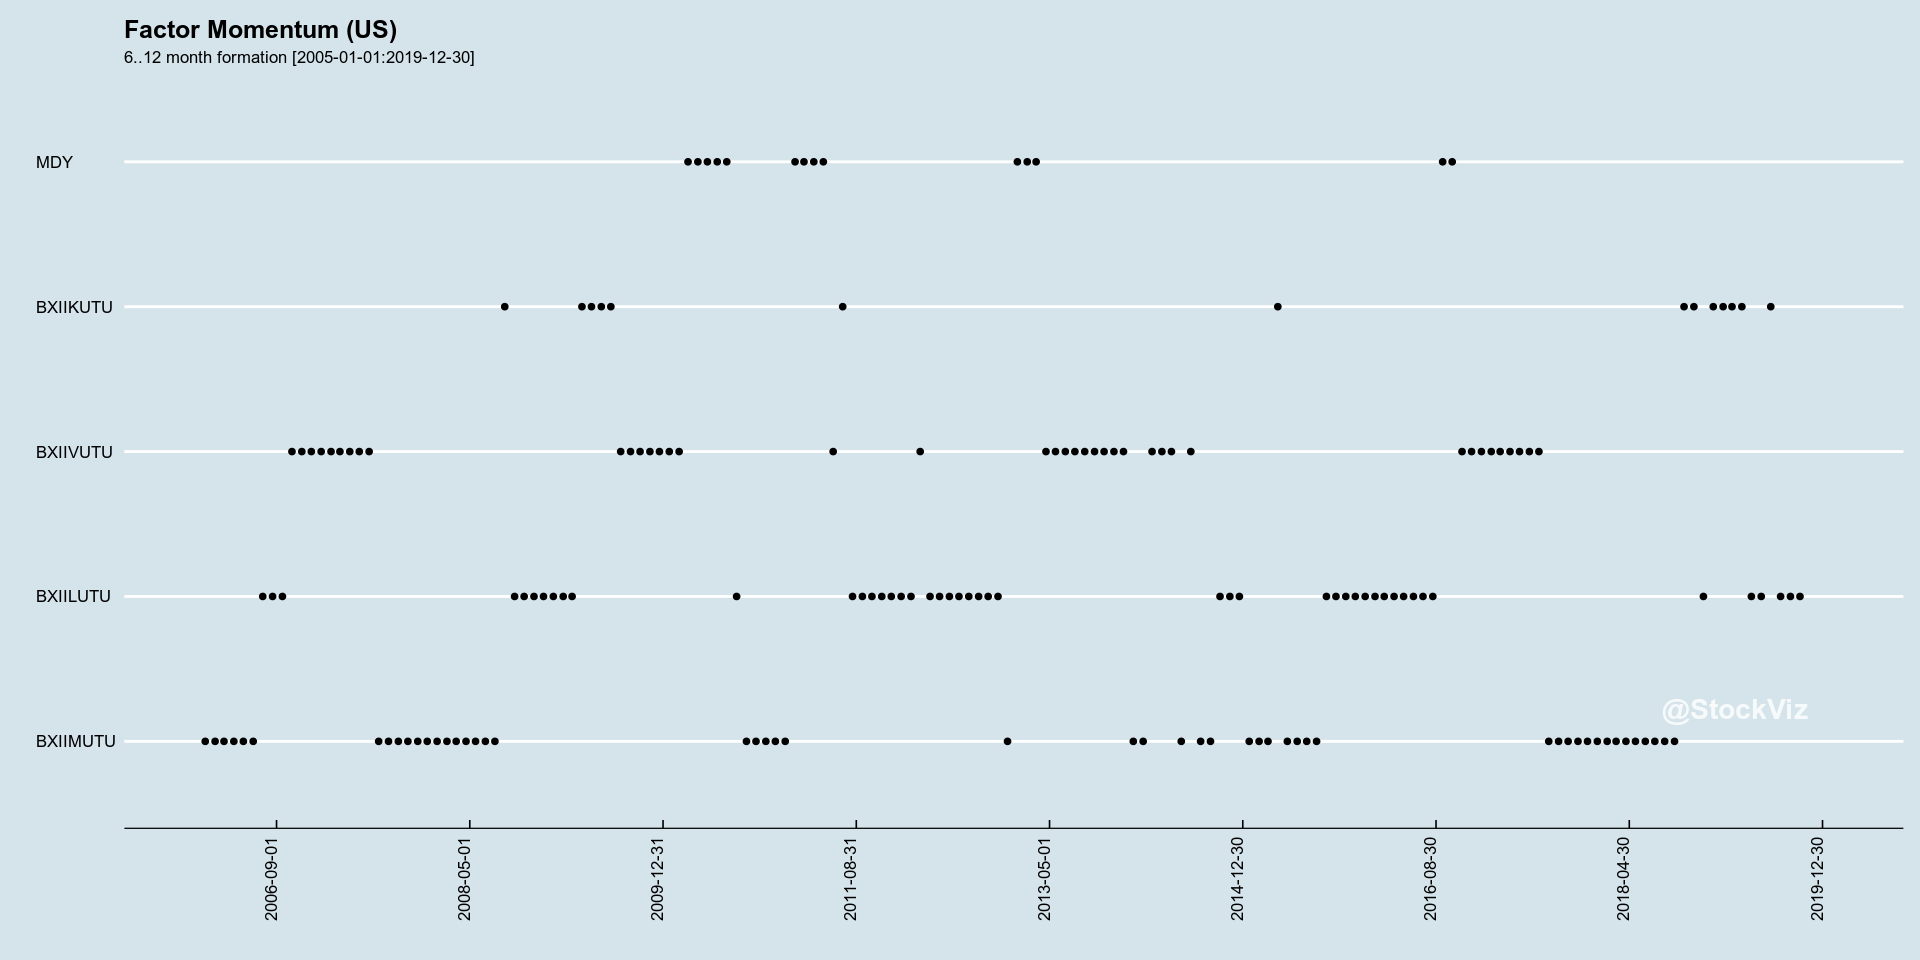

In [10]:
makePlots(factorMomXts2, "Factor Momentum (US)", "6..12 month formation")

## Buy whatever gave the highest return the previous month

In [11]:
lb <- 1
factorMomXts <- rollapply(allRets, lb, function(X){
    maxIndex <- as.numeric(which.max(X[, 1:length(indexNames)]))
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

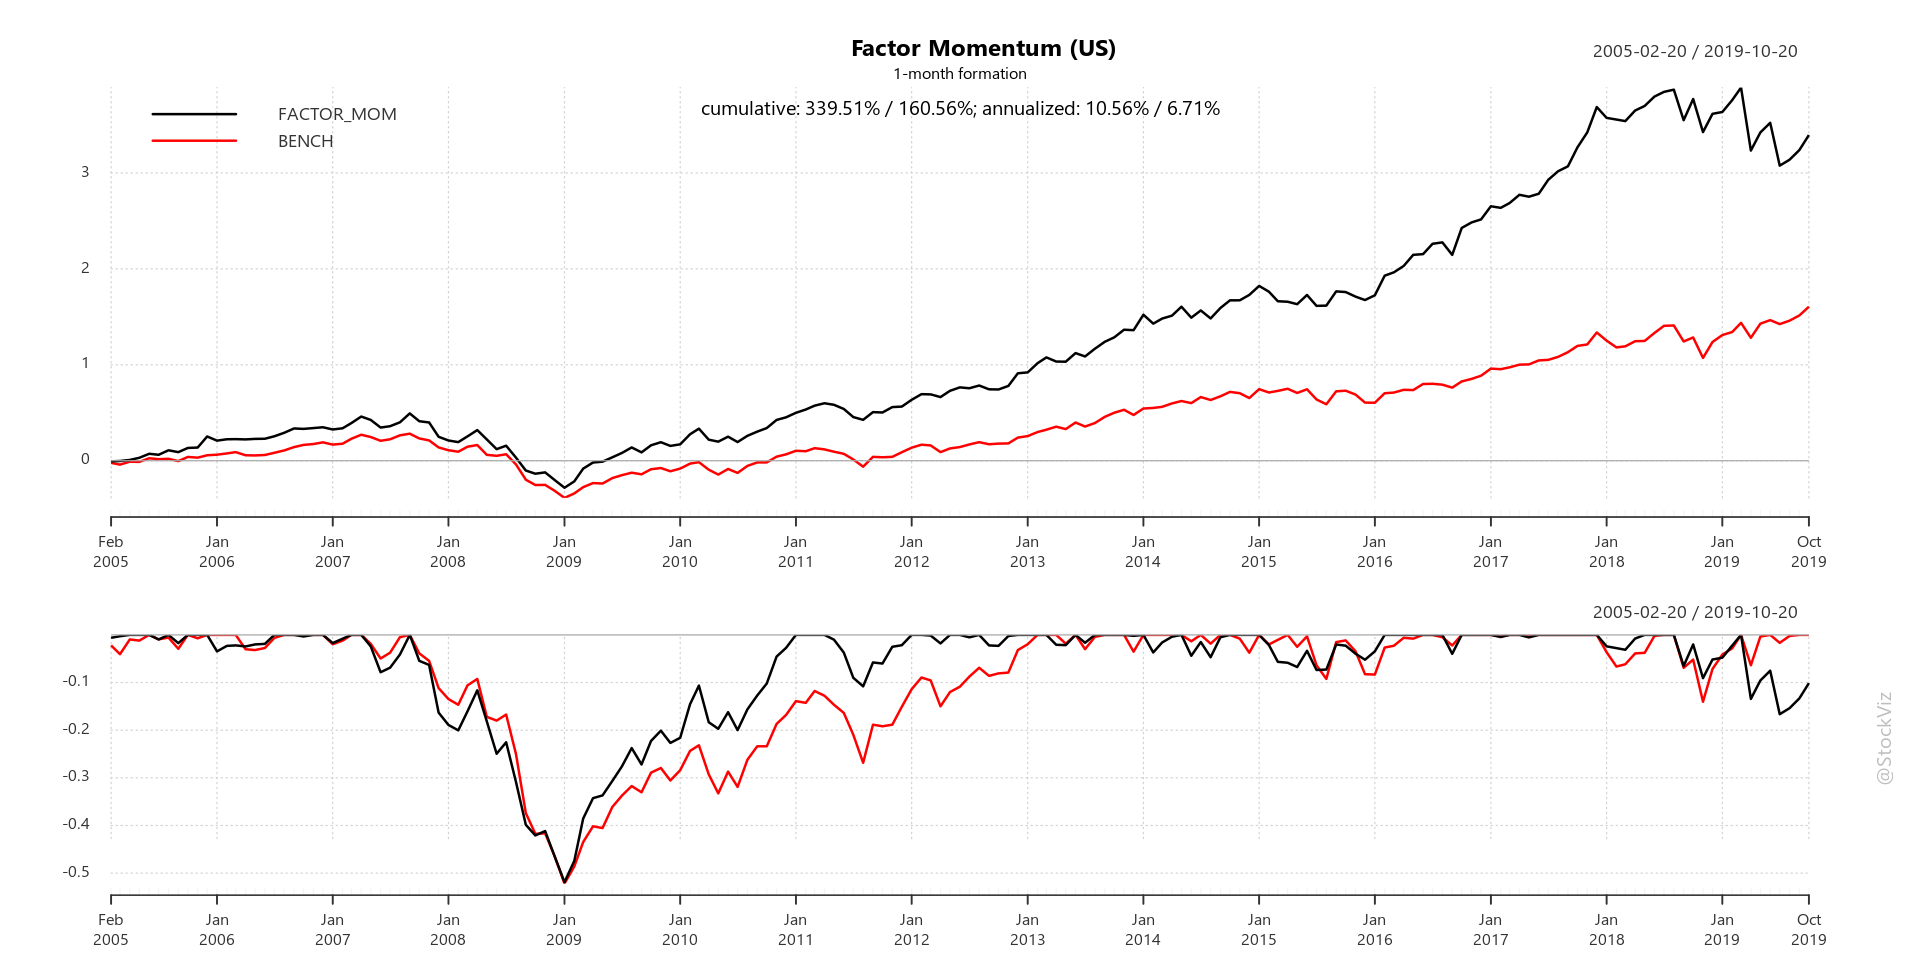

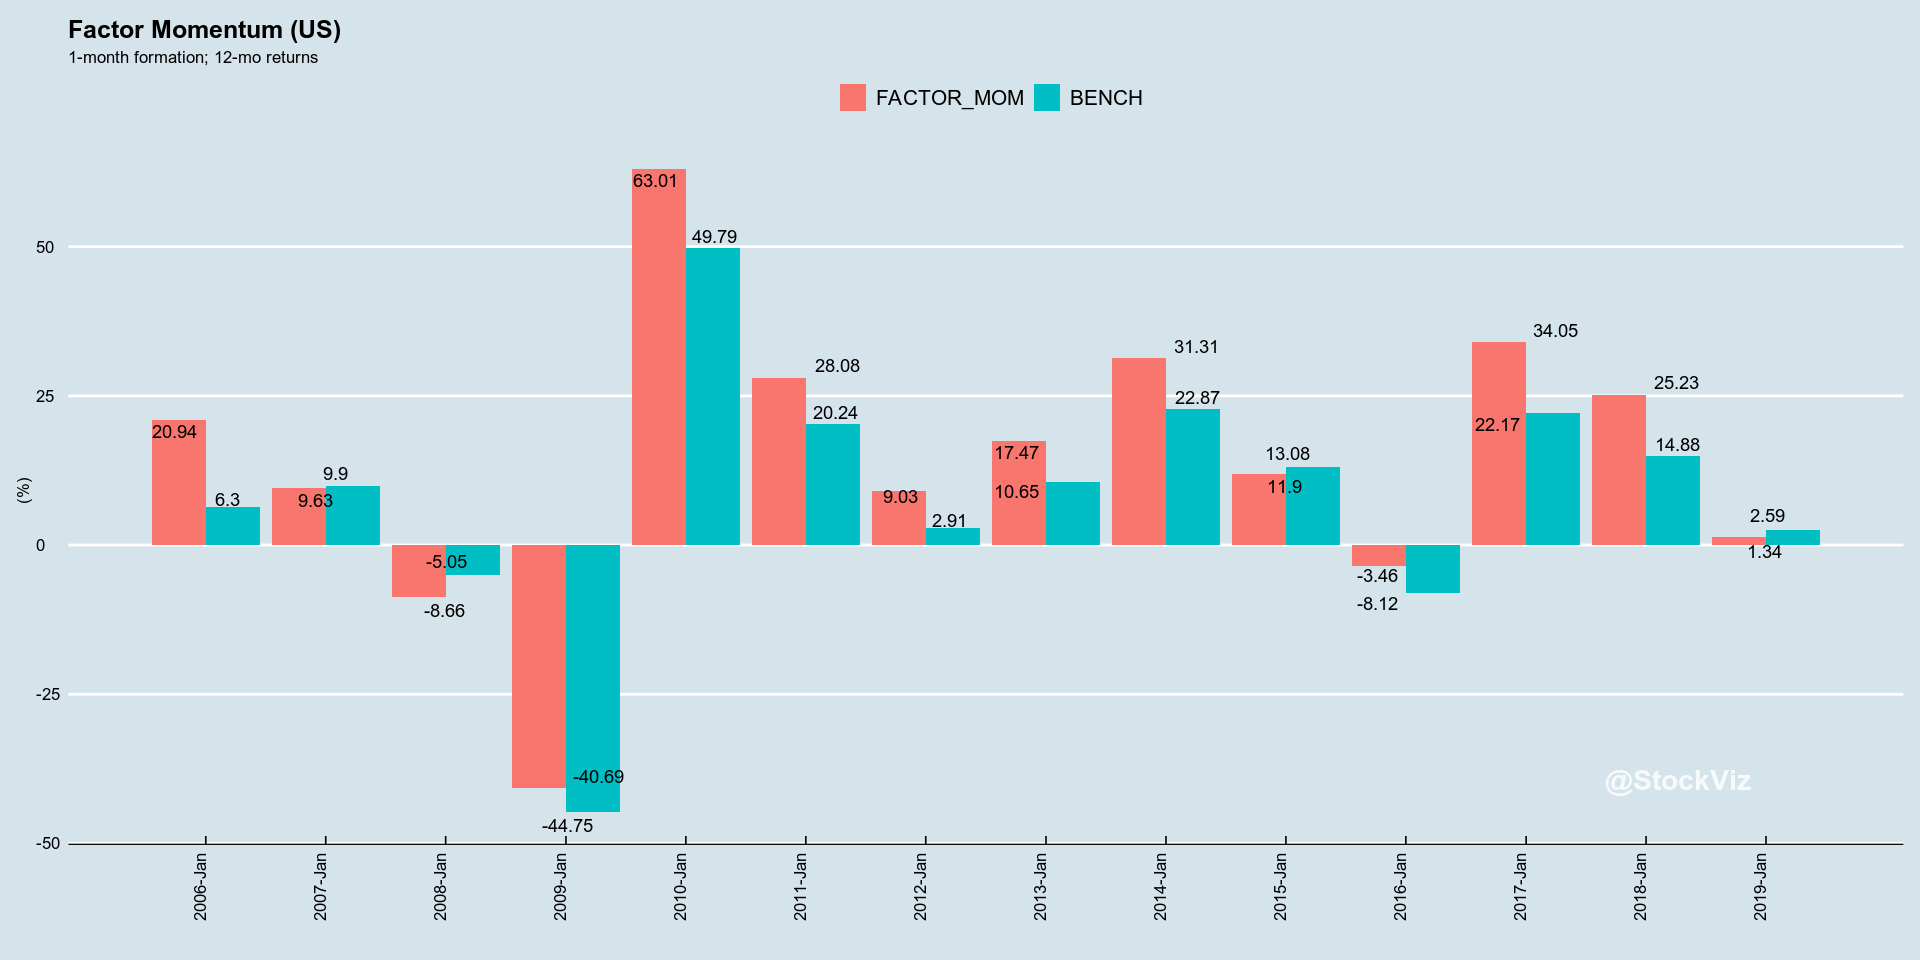

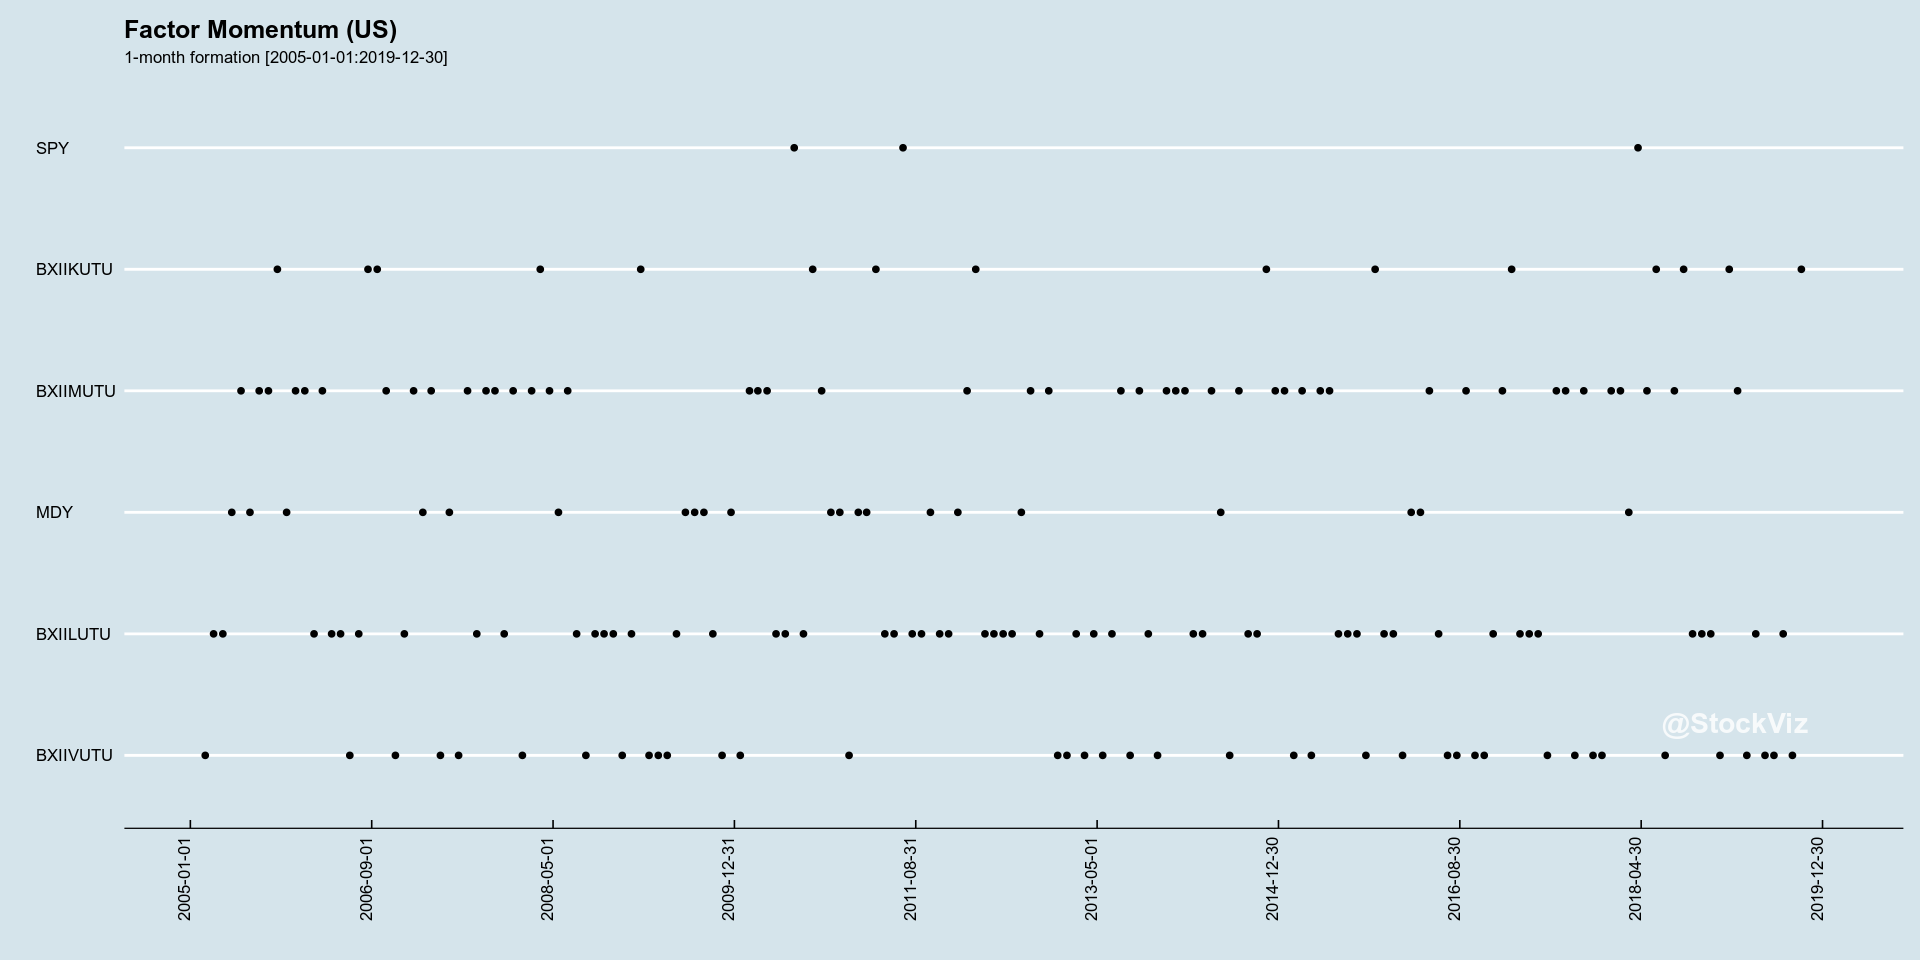

In [12]:
makePlots(factorMomXts, "Factor Momentum (US)", "1-month formation")

## Buy whatever gave lowest returns in the last 12-months

In [13]:
lb <- 12
factorMomXts <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        cumRets <- c(cumRets, as.numeric(Return.cumulative(X[,i])))
    }
    minIndex <- which.min(cumRets)
    return(xts(matrix(c(minIndex, X[lb, minIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

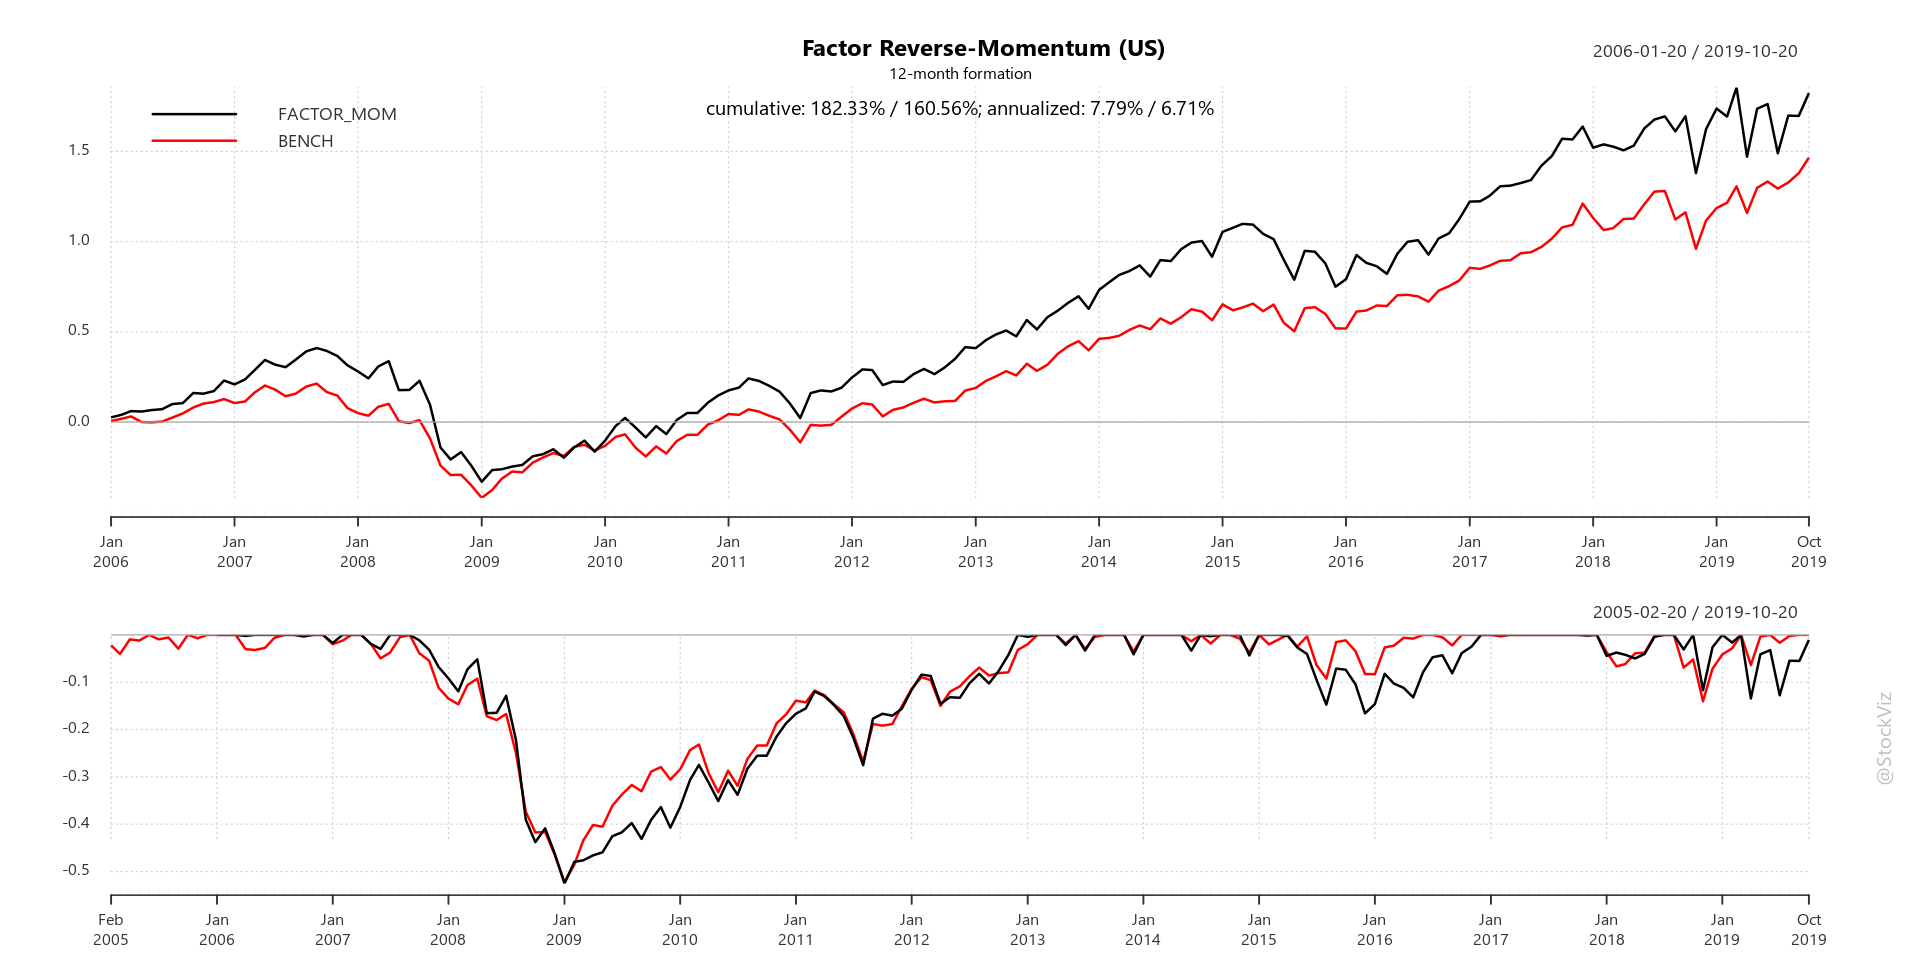

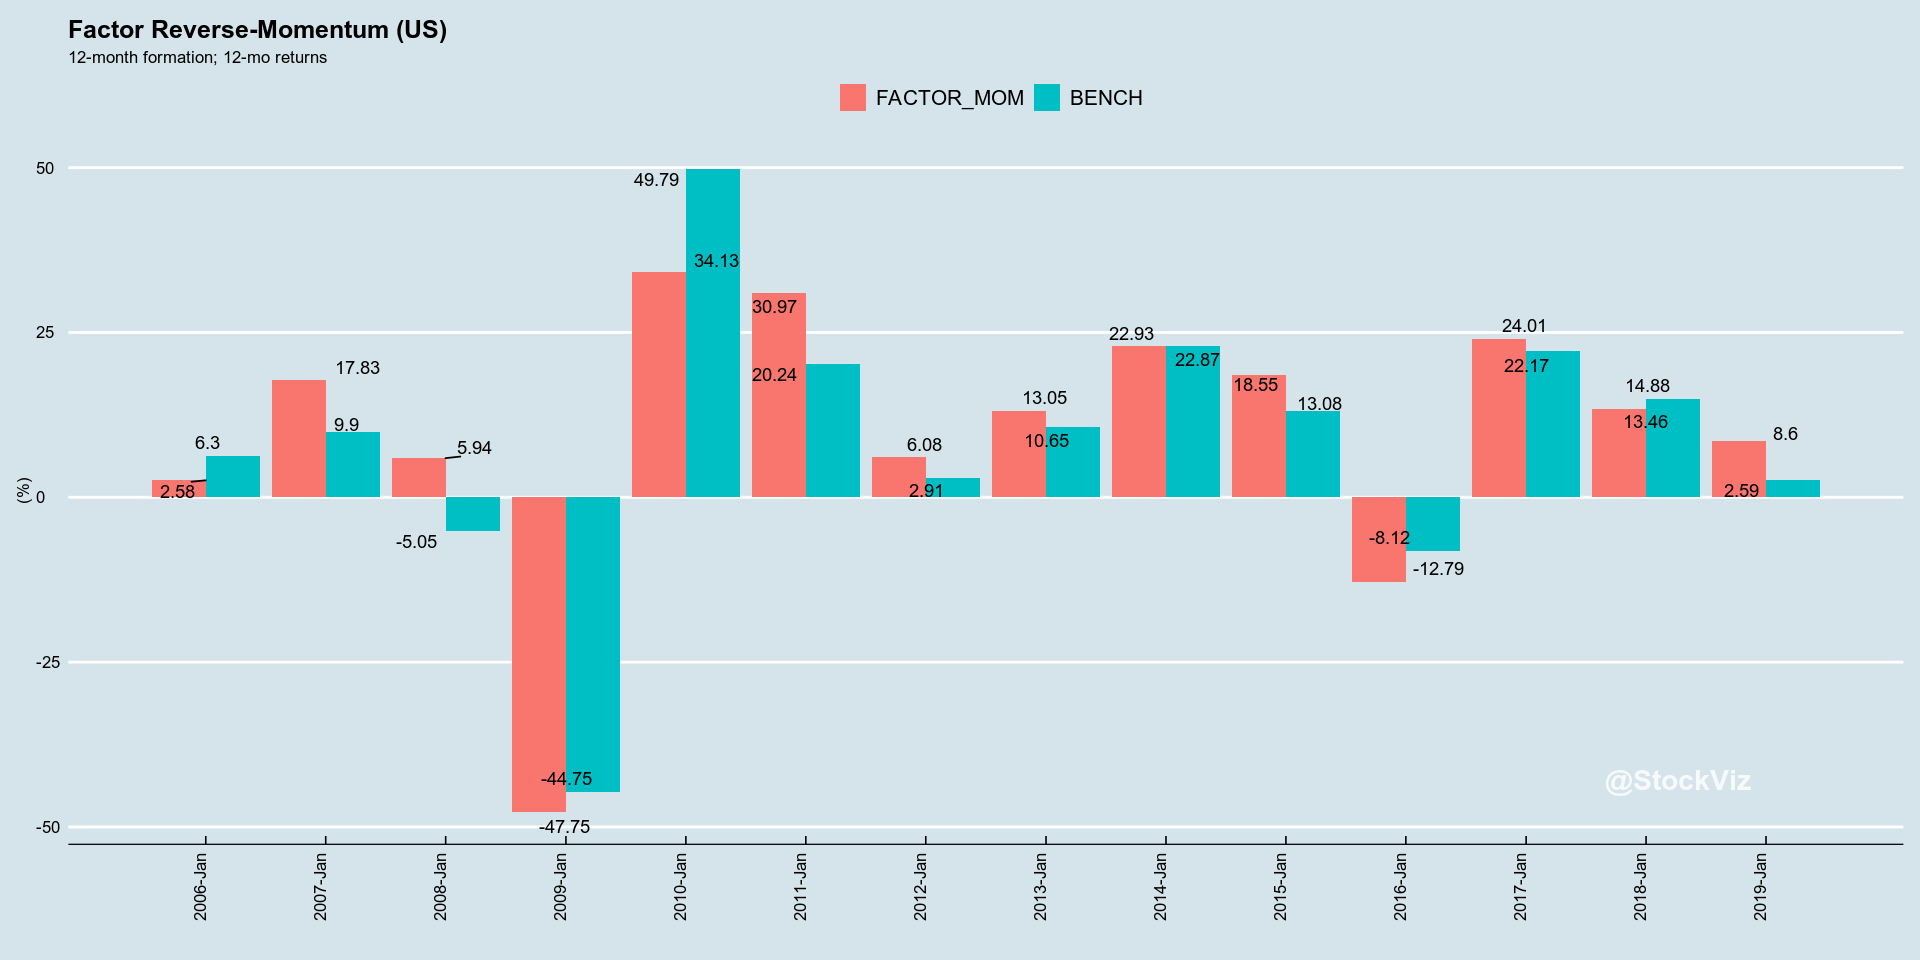

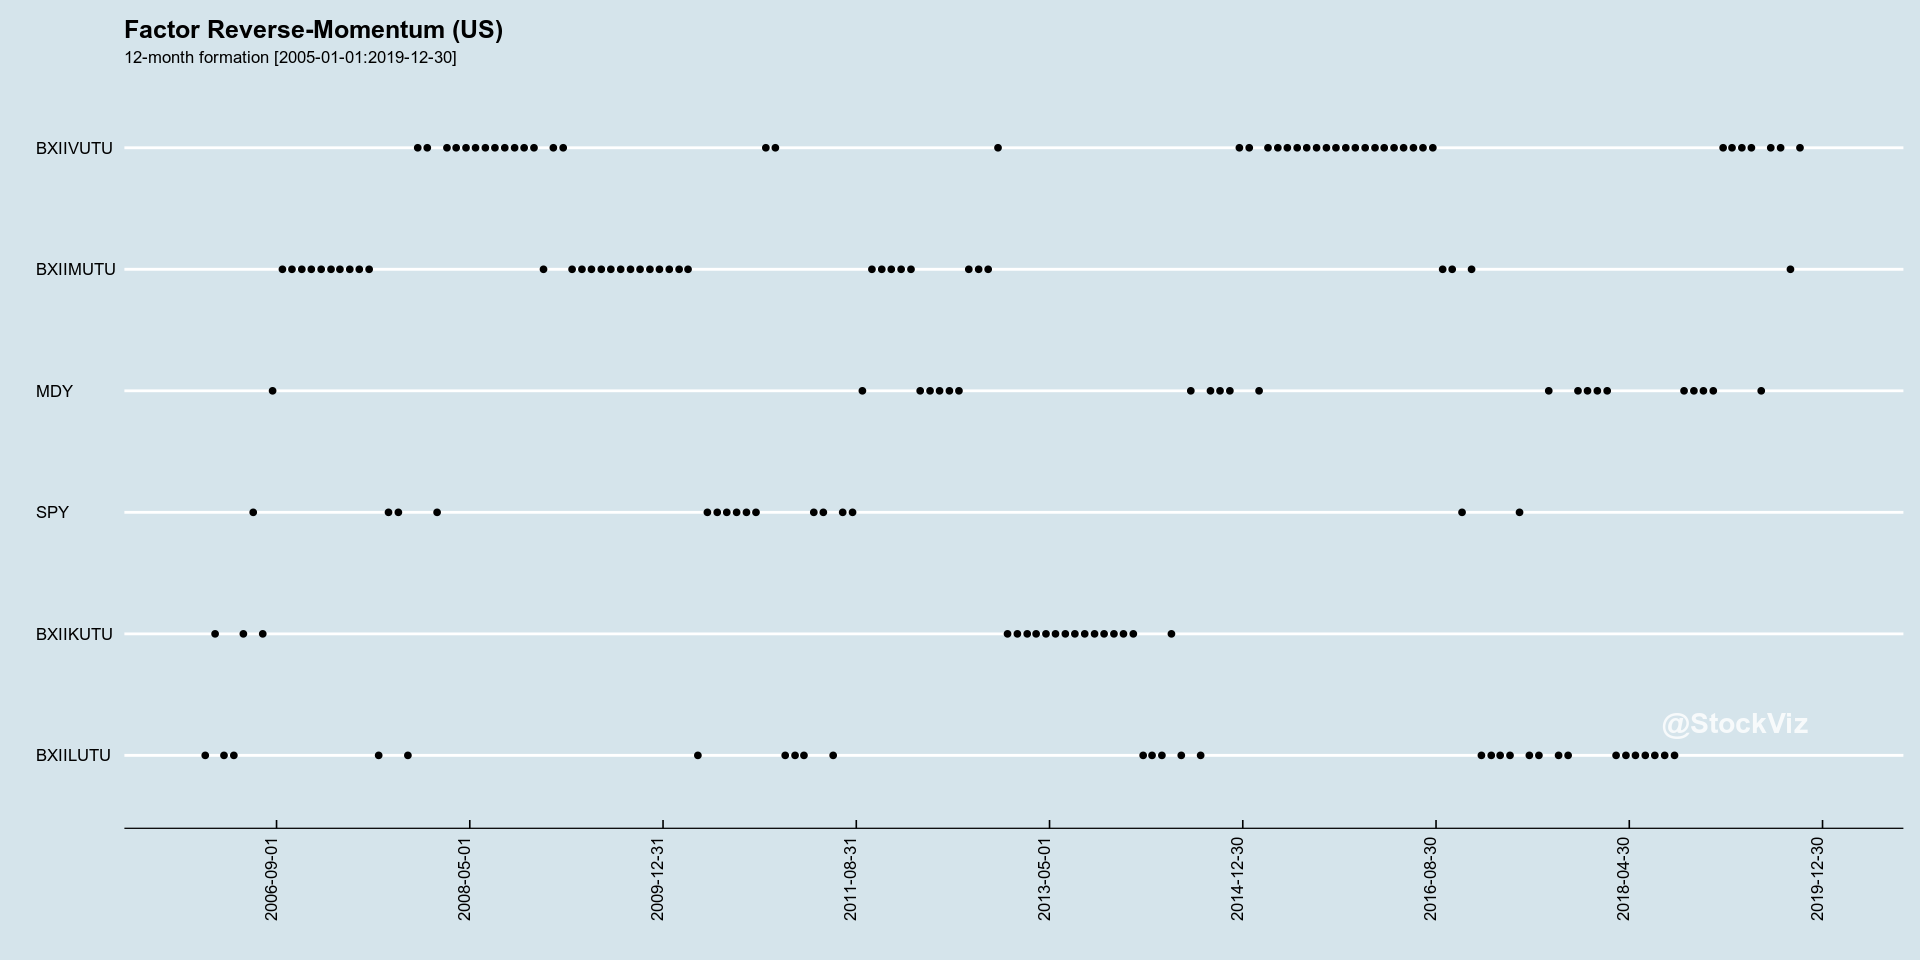

In [14]:
makePlots(factorMomXts, "Factor Reverse-Momentum (US)", "12-month formation")

## Buy whatever gave lowest returns in the last month

In [15]:
lb <- 1
factorMomXts <- rollapply(allRets, lb, function(X){
    maxIndex <- as.numeric(which.min(X[, 1:length(indexNames)]))
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

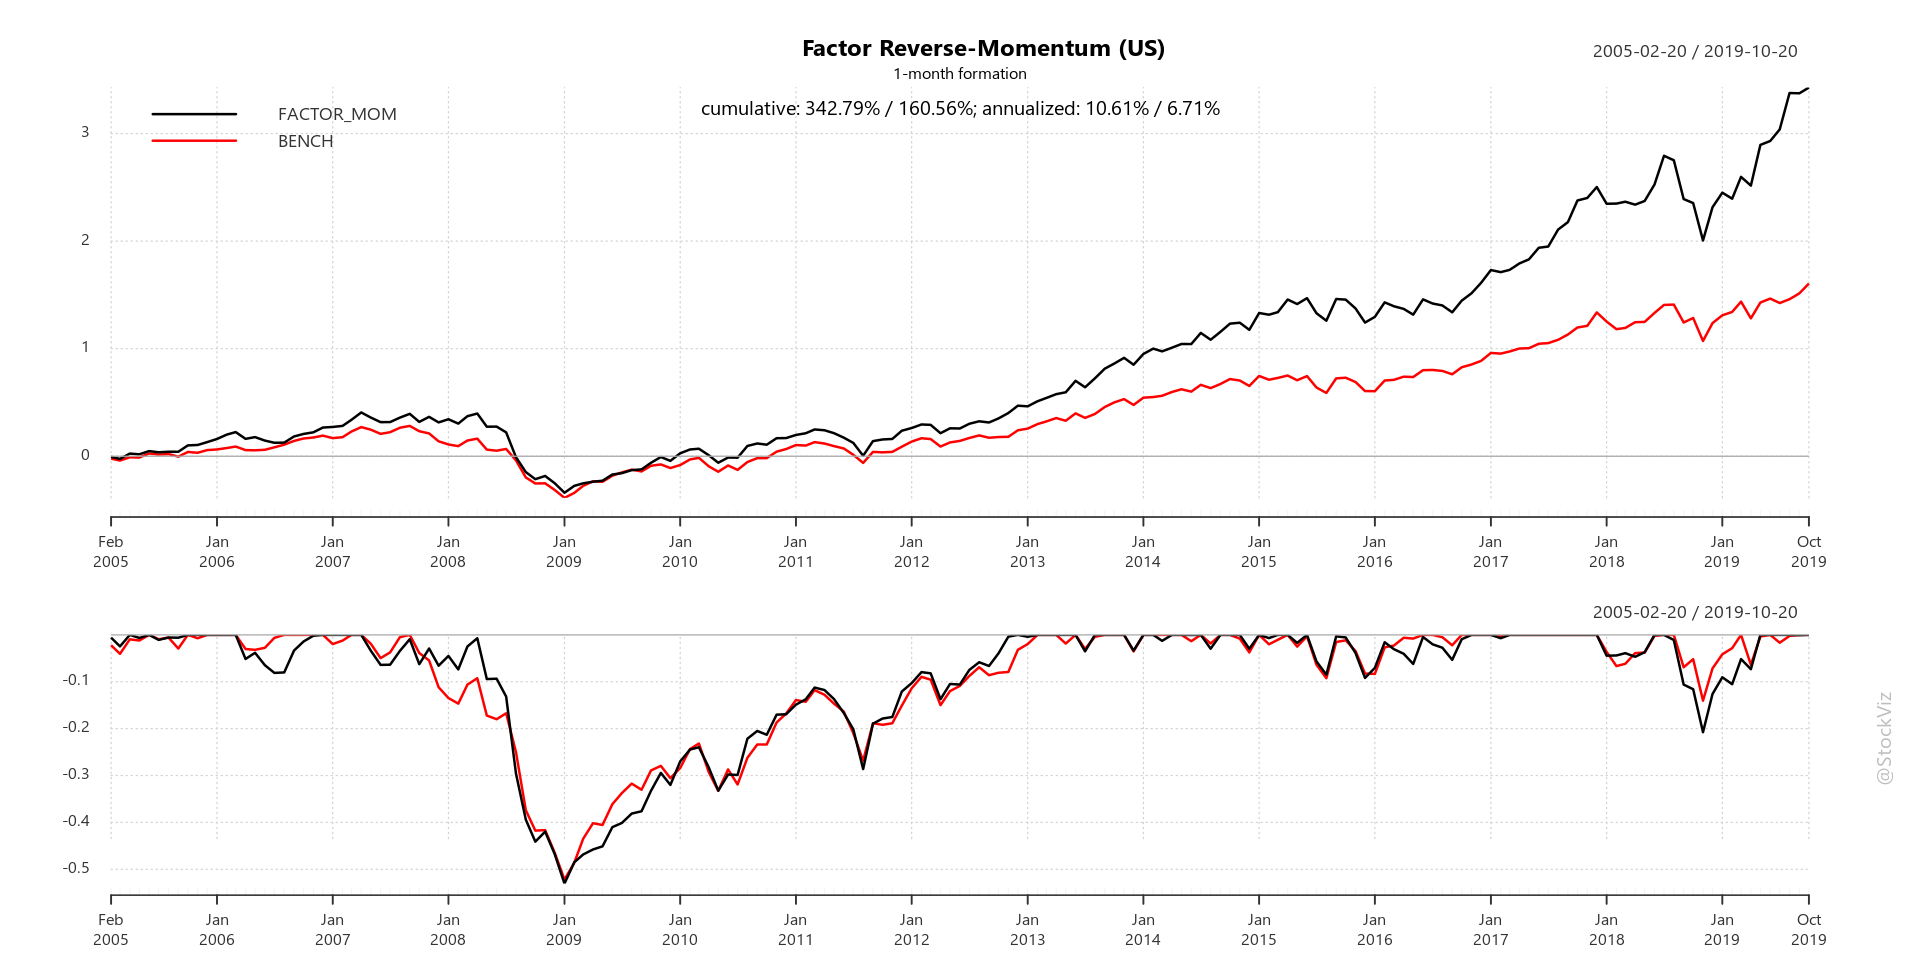

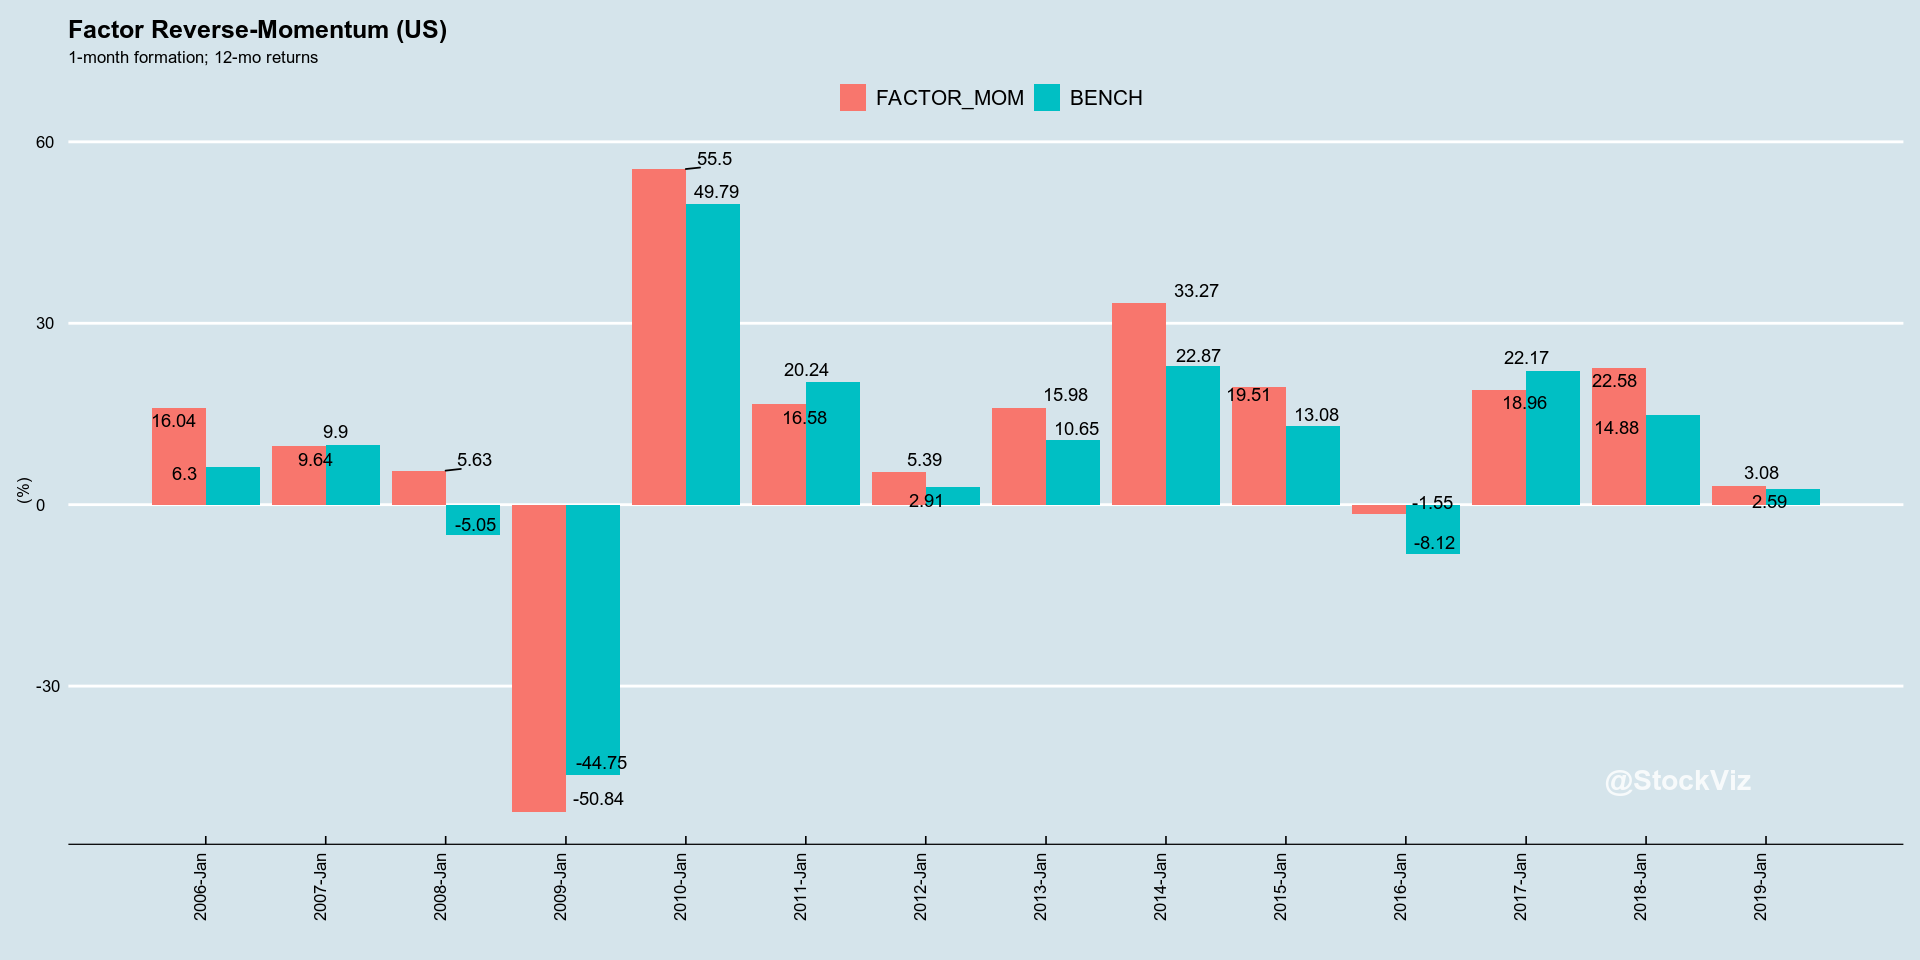

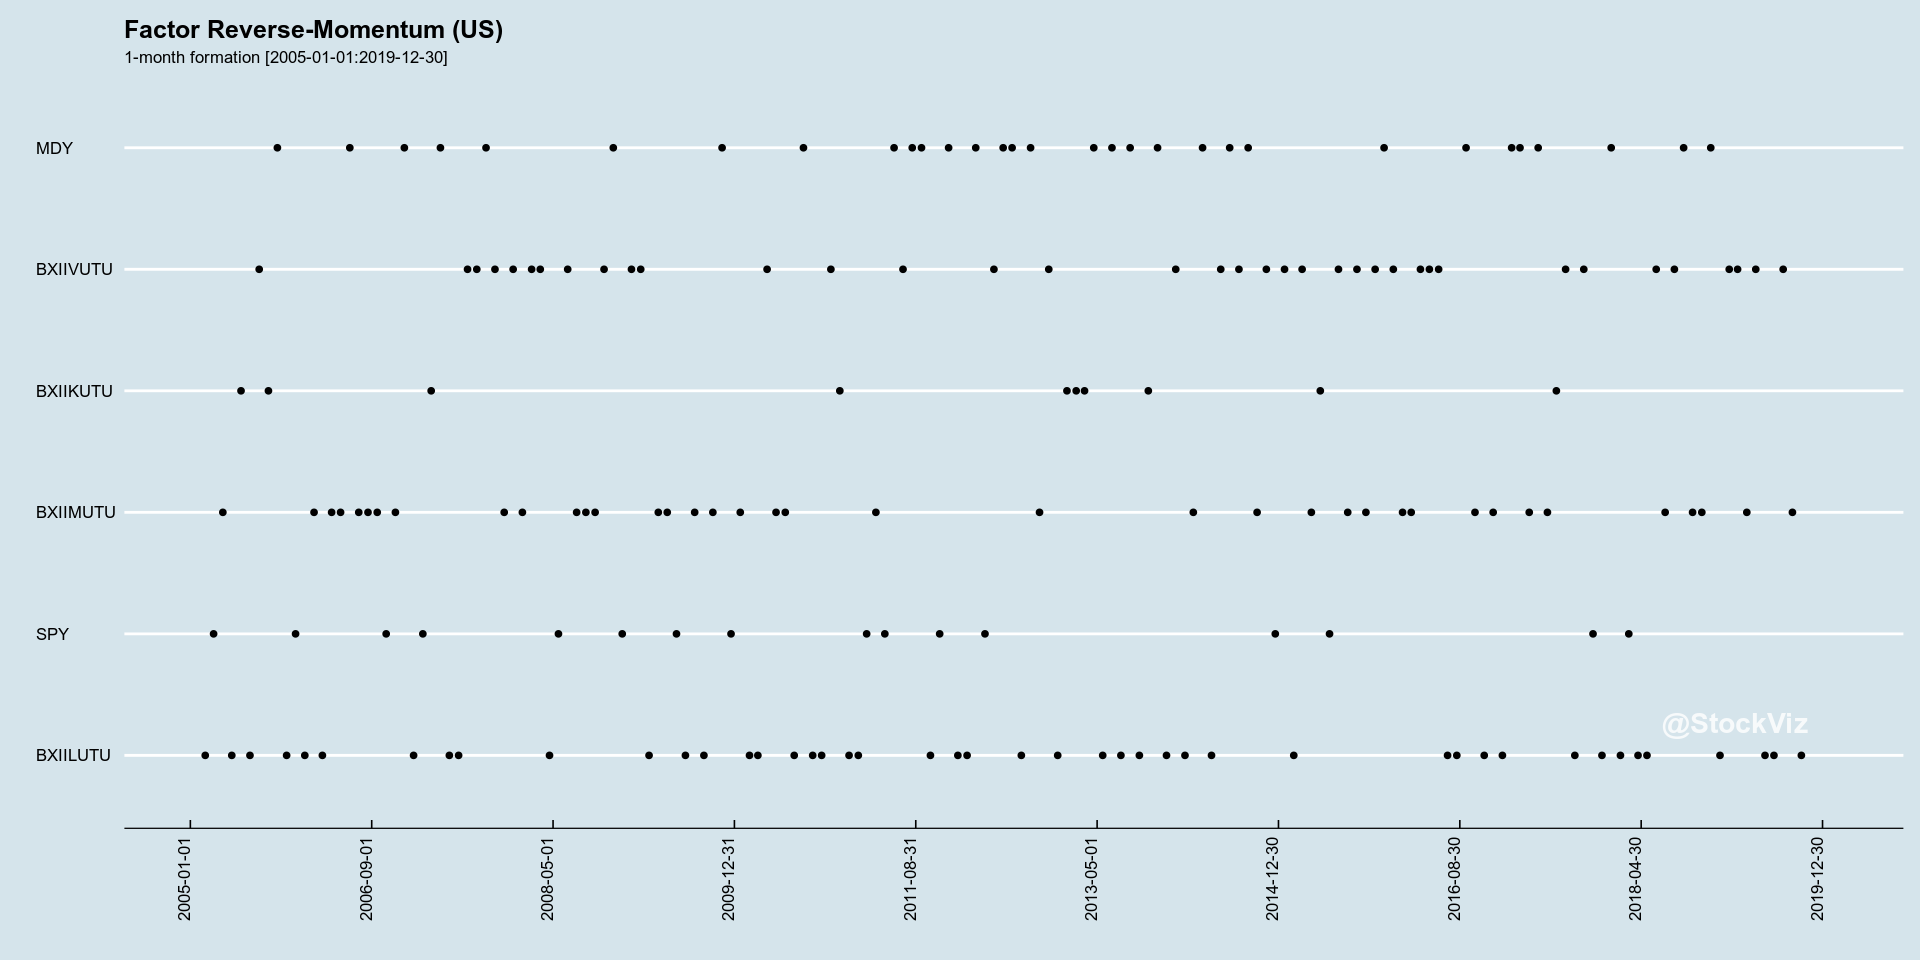

In [16]:
makePlots(factorMomXts, "Factor Reverse-Momentum (US)", "1-month formation")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!